# Analysis and prediction of collisions for space debris

In [356]:
READ = True
WRITE = False
REQUEST = False

In [357]:
import pandas as pd
import numpy as np
import pickle

In [358]:
def TleRespose2df(tle_response):
    import tletools
    out = tle_response.text.strip()
    tl = tletools.TLE.loads(out)

    df = pd.DataFrame()
    for i in tl:
        new_df = pd.DataFrame([i.asdict()])
        df = pd.concat([df, new_df], ignore_index=True)

    return df

In [359]:
if REQUEST:
    import yaml

    with open("config.yaml", 'r') as ymlfile:
        pw = yaml.load(ymlfile, Loader=yaml.FullLoader)
    import requests

    # Space-Track credentials (replace with your actual credentials)
    USERNAME = pw['username']
    PASSWORD = pw['password']

    # Space-Track API URL for the TLE query
    TLE_URL = "https://www.space-track.org/basicspacedata/query/class/gp/EPOCH/%3Enow-30/MEAN_MOTION/%3E11.25/format/3le"

    # Login payload
    LOGIN_URL = "https://www.space-track.org/ajaxauth/login"

    # Start session
    session = requests.Session()

    # Authenticate
    login_payload = {
        "identity": USERNAME,
        "password": PASSWORD
    }
    response = session.post(LOGIN_URL, data=login_payload)

    if response.status_code == 200:
        print("Login successful.")

        # Download TLE file
        tle_response = session.get(TLE_URL)

        if tle_response.status_code == 200:
            df = TleRespose2df(tle_response)
            print("TLE data loaded")
        else:
            print(f"Failed to retrieve TLE data. Status code: {tle_response.status_code}")
    else:
        print(f"Login failed. Status code: {response.status_code}")


In [360]:
if WRITE:
    df.to_parquet("tledata.parquet")

In [361]:
if READ:
    df = pd.read_parquet("tledata2.parquet")
df = df.loc[pd.to_numeric(df['norad'], errors='coerce').notna()].copy()
df['norad'] = df['norad'].astype(str).astype(int)
print(f"Unique: {len(df['norad'].unique())}")

Unique: 22555


In [362]:
col = pd.read_csv("TIP_data.csv")
col

,NORAD_CAT_ID,MSG_EPOCH,INSERT_EPOCH,DECAY_EPOCH,WINDOW,REV,DIRECTION,LAT,LON,INCL,NEXT_REPORT,ID,HIGH_INTEREST,OBJECT_NUMBER
0,60,2012-03-24 15:19:00,2012-03-24 09:23:00,2012-03-28 03:04:00,2880,58623,ascending,-42.7,13.3,49.9,72,3007,N,60
1,60,2012-03-25 03:50:00,2012-03-24 21:55:48,2012-03-28 04:18:00,2880,58624,descending,-41.2,272.6,49.9,48,3010,N,60
2,60,2012-03-26 04:36:00,2012-03-25 22:40:37,2012-03-28 03:39:00,1440,58624,ascending,48.3,125.8,49.9,24,3013,N,60
3,60,2012-03-27 03:47:00,2012-03-26 21:50:52,2012-03-28 02:47:00,840,58624,descending,-33.4,282.0,49.9,12,3020,N,60
4,60,2012-03-27 14:54:00,2012-03-27 09:00:14,2012-03-28 02:23:00,420,58623,descending,38.7,212.3,49.9,6,3023,N,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17812,62608,2025-01-28 19:31:00,2025-01-28 19:36:21,2025-01-29 19:37:00,300,249,ascending,-49.9,126.8,51.6,12,45707,N,62608
17813,62608,2025-01-29 06:13:00,2025-01-29 06:26:37,2025-01-29 18:31:00,180,250,ascending,8.0,219.7,51.6,6,45724,N,62608
17814,62608,2025-01-29 12:25:00,2025-01-29 12:36:20,2025-01-29 18:32:00,180,250,ascending,12.8,223.3,51.6,2,45731,N,62608
17815,62608,2025-01-29 15:54:00,2025-01-29 16:26:26,2025-01-29 17:52:00,27,250,descending,-22.8,62.7,51.6,0,45735,N,62608


In [363]:
col["NORAD_CAT_ID"] = col["NORAD_CAT_ID"].astype(int)
col_list = col["NORAD_CAT_ID"].to_list()

In [364]:
df = df.loc[pd.to_numeric(df['norad'], errors='coerce').notna()].copy()
df['norad'] = df['norad'].astype(str).astype(int)

# df.loc[:, "collision"] = df["norad"].isin(col["NORAD_CAT_ID"])
df["collision"] = False
df.loc[df["norad"].isin(col_list), "collision"] = True
df["collision"] = df["collision"].astype(bool)
df.loc[:, "a"] = (398600 / ((df["n"] * (2 * np.pi) / 86400) ** 2)) ** (1/3)

# oe = ['dn_o2', 'ddn_o6', 'bstar', 'inc', 'raan','ecc', 'argp', 'M', 'n', 'a']
oe = ['dn_o2', 'ddn_o6', 'bstar', 'inc', 'raan','ecc', 'argp', 'M', 'n']
df[df["norad"] == 62608]

,name,norad,classification,int_desig,epoch_year,epoch_day,dn_o2,ddn_o6,bstar,set_num,inc,raan,ecc,argp,M,n,rev_num,collision,a
602,0 DRAGON CRS-31 DEB,62608,U,24200B,2025,29.653328,0.055156,0.000012,0.000395,999,51.6226,259.7984,0.000599,314.7115,89.5839,16.400532,247,True,6543.795528


In [365]:
print(f"Unique: {len(df['norad'].unique())}")

Unique: 22555


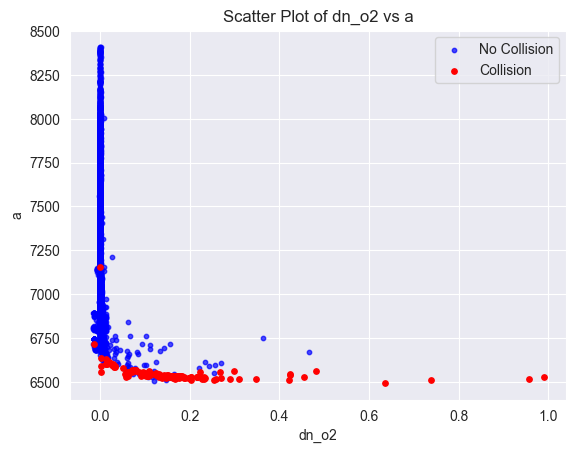

In [366]:
import matplotlib.pyplot as plt

# Define colors: red for collision, blue otherwise
colors = df["collision"].map({True: "red", False: "blue"})

x = "dn_o2"
y = "a"

# Plot non-collision points first (blue), then collision points (red)
plt.scatter(df[x][~df["collision"]], df[y][~df["collision"]], c="blue", s=10, alpha=0.7, label="No Collision")
plt.scatter(df[x][df["collision"]], df[y][df["collision"]], c="red", s=15, alpha=1.0, label="Collision")

plt.xlabel(x)
plt.ylabel(y)
plt.title(f"Scatter Plot of {x} vs {y}")
plt.legend()
plt.grid(True)
plt.show()

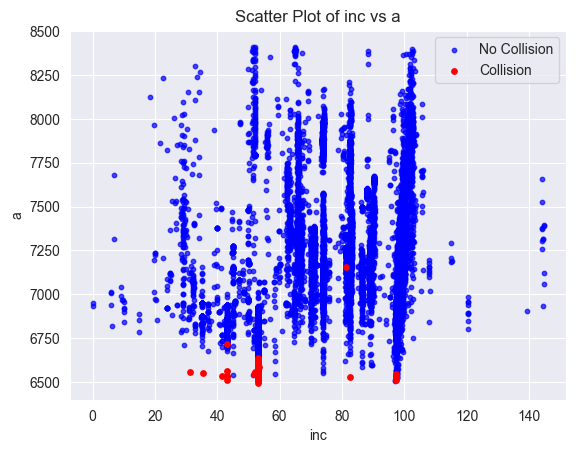

In [367]:
import matplotlib.pyplot as plt

# Define colors: red for collision, blue otherwise
colors = df["collision"].map({True: "red", False: "blue"})

x = "inc"
y = "a"

# Plot non-collision points first (blue), then collision points (red)
plt.scatter(df[x][~df["collision"]], df[y][~df["collision"]], c="blue", s=10, alpha=0.7, label="No Collision")
plt.scatter(df[x][df["collision"]], df[y][df["collision"]], c="red", s=15, alpha=1.0, label="Collision")

plt.xlabel(x)
plt.ylabel(y)
plt.title(f"Scatter Plot of {x} vs {y}")
plt.legend()
plt.grid(True)
plt.show()


In [368]:
oe

['dn_o2', 'ddn_o6', 'bstar', 'inc', 'raan', 'ecc', 'argp', 'M', 'n']

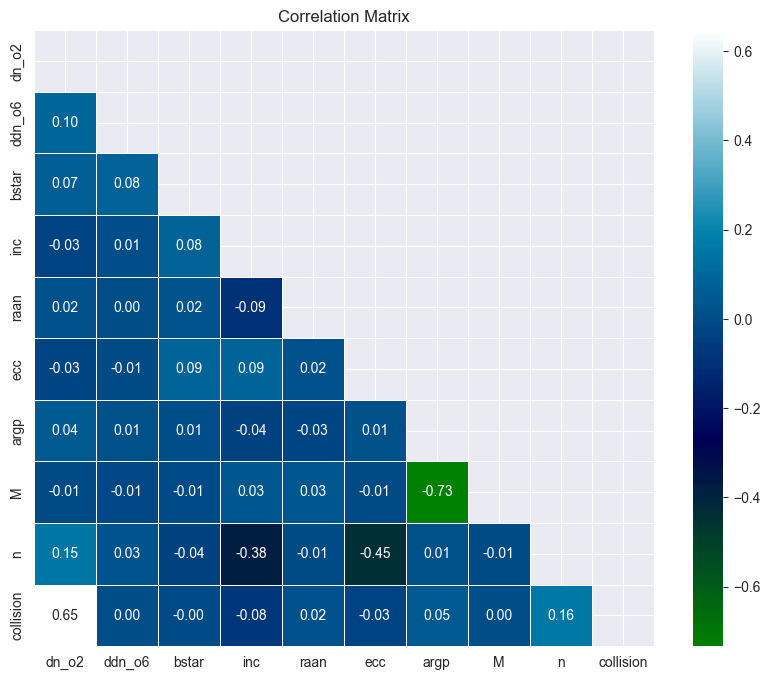

In [369]:
import seaborn as sns
oec = oe + ["collision"]
corr_matrix = df[oec].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", linewidths=0.5, cmap="ocean")
plt.title("Correlation Matrix")
plt.show()

In [370]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

X = df[oe]   # Feature columns
y = df['collision']      # Target column (True if collision, False otherwise)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the Decision Tree Classifier
# clf = DecisionTreeClassifier(random_state=42)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Predict the target on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      8973
        True       0.94      0.94      0.94        49

    accuracy                           1.00      9022
   macro avg       0.97      0.97      0.97      9022
weighted avg       1.00      1.00      1.00      9022

Accuracy: 0.9993349589891377


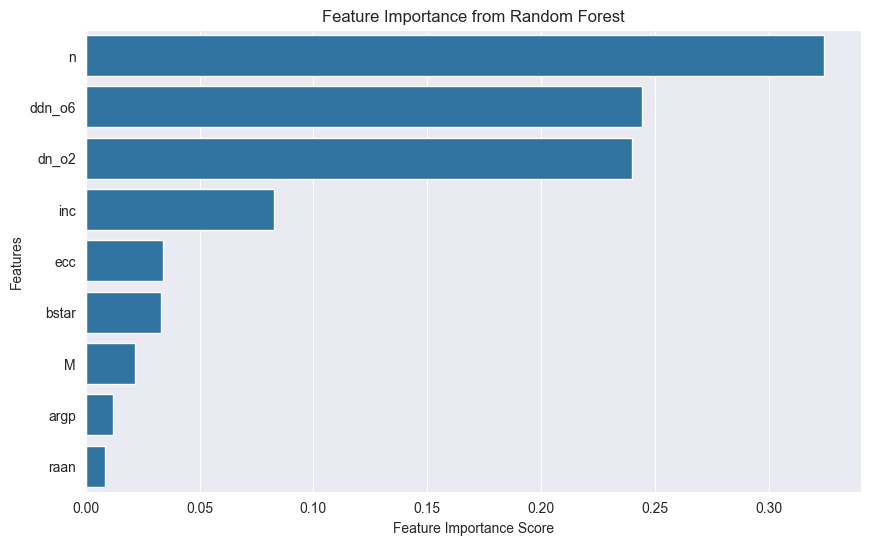

In [371]:
# Get feature importances
feature_importance = clf.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.show()

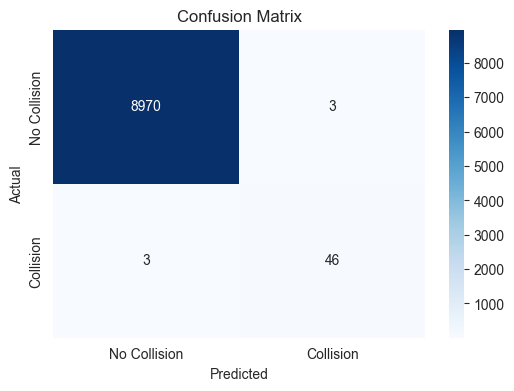

In [372]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix from test data and predictions
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Collision', 'Collision'],
            yticklabels=['No Collision', 'Collision'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


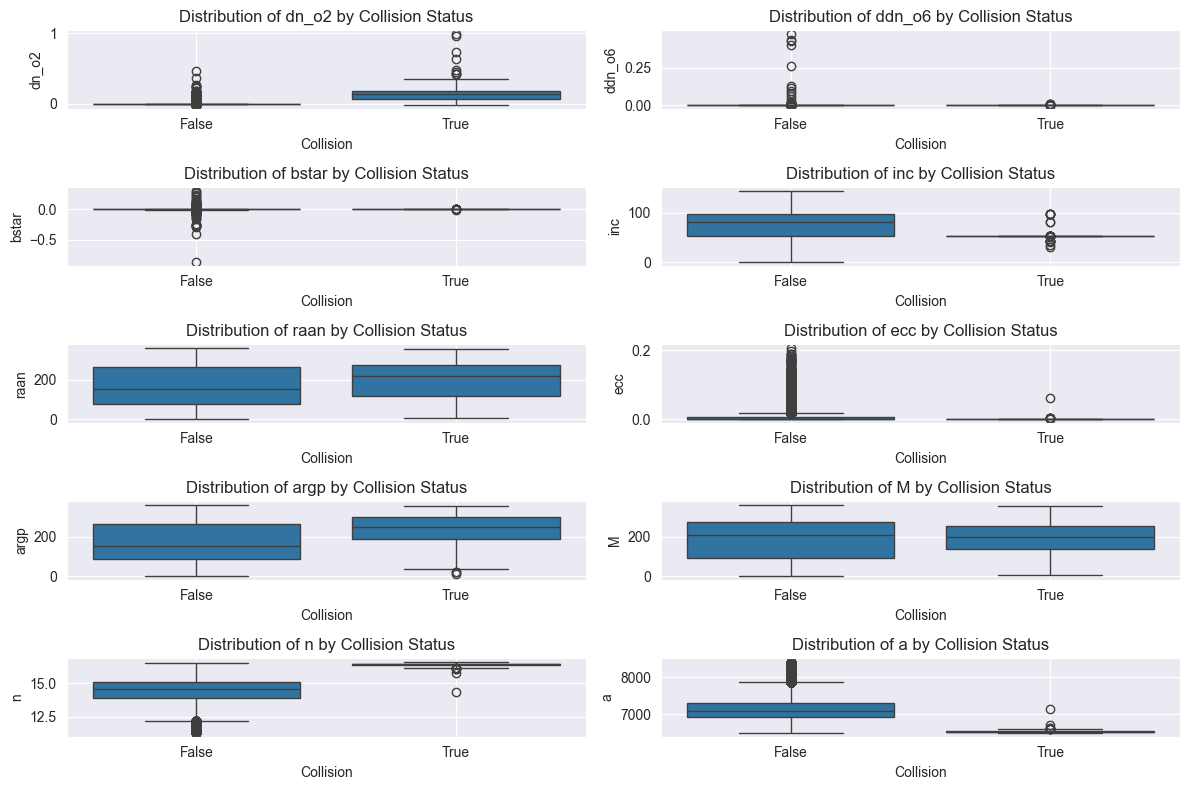

In [373]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows and columns for subplots
n_rows = 5
n_cols = 2

oef = oe + ["a"]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten in case of a single row

# Loop through each orbital element and create a boxplot
for i, element in enumerate(oef):
    sns.boxplot(x=df["collision"], y=df[element], ax=axes[i])
    axes[i].set_xlabel("Collision")
    axes[i].set_ylabel(element)
    axes[i].set_title(f"Distribution of {element} by Collision Status")
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

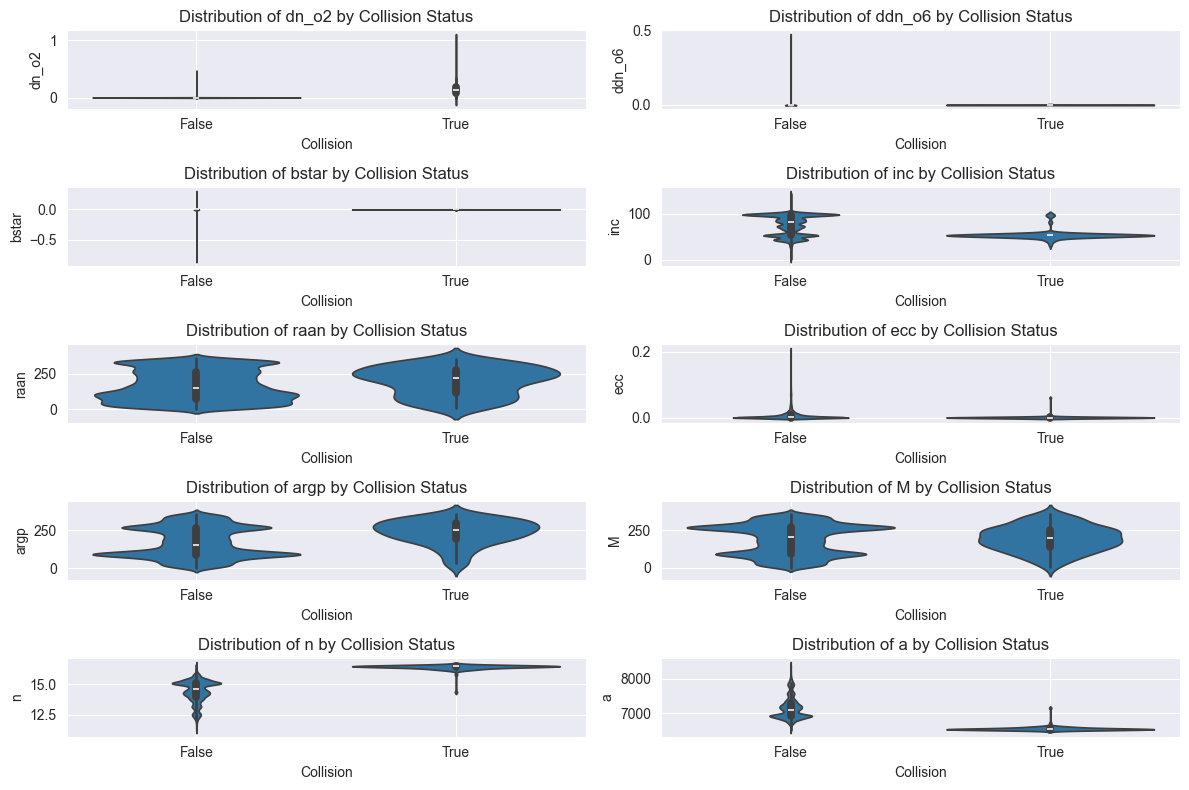

In [374]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows and columns for subplots
n_rows = 5  # Arrange in 3 columns
n_cols = 2  # Max 3 columns

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten in case of a single row

# Loop through each orbital element and create a violin plot
for i, element in enumerate(oef):
    sns.violinplot(x=df["collision"], y=df[element], ax=axes[i], inner="box")
    axes[i].set_xlabel("Collision")
    axes[i].set_ylabel(element)
    axes[i].set_title(f"Distribution of {element} by Collision Status")
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [375]:
# Predict given orbital parameters
df_pred = df.iloc[[0]][oe]
print(f"TIP message prediction: {clf.predict(df_pred)}")
df_pred

TIP message prediction: [False]


,dn_o2,ddn_o6,bstar,inc,raan,ecc,argp,M,n
291,0.000064,0.0,0.003299,99.047,97.8689,0.008632,207.0401,152.6261,14.139003


In [376]:
len(col[col["HIGH_INTEREST"]=='Y'])

4741

In [377]:
col

,NORAD_CAT_ID,MSG_EPOCH,INSERT_EPOCH,DECAY_EPOCH,WINDOW,REV,DIRECTION,LAT,LON,INCL,NEXT_REPORT,ID,HIGH_INTEREST,OBJECT_NUMBER
0,60,2012-03-24 15:19:00,2012-03-24 09:23:00,2012-03-28 03:04:00,2880,58623,ascending,-42.7,13.3,49.9,72,3007,N,60
1,60,2012-03-25 03:50:00,2012-03-24 21:55:48,2012-03-28 04:18:00,2880,58624,descending,-41.2,272.6,49.9,48,3010,N,60
2,60,2012-03-26 04:36:00,2012-03-25 22:40:37,2012-03-28 03:39:00,1440,58624,ascending,48.3,125.8,49.9,24,3013,N,60
3,60,2012-03-27 03:47:00,2012-03-26 21:50:52,2012-03-28 02:47:00,840,58624,descending,-33.4,282.0,49.9,12,3020,N,60
4,60,2012-03-27 14:54:00,2012-03-27 09:00:14,2012-03-28 02:23:00,420,58623,descending,38.7,212.3,49.9,6,3023,N,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17812,62608,2025-01-28 19:31:00,2025-01-28 19:36:21,2025-01-29 19:37:00,300,249,ascending,-49.9,126.8,51.6,12,45707,N,62608
17813,62608,2025-01-29 06:13:00,2025-01-29 06:26:37,2025-01-29 18:31:00,180,250,ascending,8.0,219.7,51.6,6,45724,N,62608
17814,62608,2025-01-29 12:25:00,2025-01-29 12:36:20,2025-01-29 18:32:00,180,250,ascending,12.8,223.3,51.6,2,45731,N,62608
17815,62608,2025-01-29 15:54:00,2025-01-29 16:26:26,2025-01-29 17:52:00,27,250,descending,-22.8,62.7,51.6,0,45735,N,62608


In [382]:
hi = col[col["HIGH_INTEREST"]=='Y']["NORAD_CAT_ID"]
li = col[col["HIGH_INTEREST"]=='N']["NORAD_CAT_ID"]
hi

53        3138
54        3138
56        3138
57        3138
59        3138
         ...  
17680    60467
17695    61044
17696    61044
17697    61044
17698    61044
Name: NORAD_CAT_ID, Length: 4741, dtype: int32

In [385]:
df["collision2"] = 0
df.loc[df["norad"].isin(li), "collision2"] = 1
df.loc[df["norad"].isin(hi), "collision2"] = 2

df[df["collision2"] == 2]

,name,norad,classification,int_desig,epoch_year,epoch_day,dn_o2,ddn_o6,bstar,set_num,inc,raan,ecc,argp,M,n,rev_num,collision,a,collision2
10968,0 CZ-2C R/B,46811,U,20076E,2025,13.974534,0.060115,0.000002,0.00051,999,35.2897,211.7451,0.000929,302.7058,181.9249,16.382352,23597,True,6548.635875,2


In [380]:
# Example: Creating three categories based on value ranges
df['collision2'] = pd.cut(df['collision2'], bins=3, labels=["Low", "Medium", "High"])

# Convert categorical labels to numerical labels
df['collision2'] = df['collision2'].astype('category').cat.codes  # Converts 'Low'=0, 'Medium'=1, 'High'=2

X = df[oe]  # Feature columns
y = df['collision2']  # Target column (now categorical with three levels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      8973
           0       0.94      0.94      0.94        49

    accuracy                           1.00      9022
   macro avg       0.97      0.97      0.97      9022
weighted avg       1.00      1.00      1.00      9022

Accuracy: 0.9993349589891377


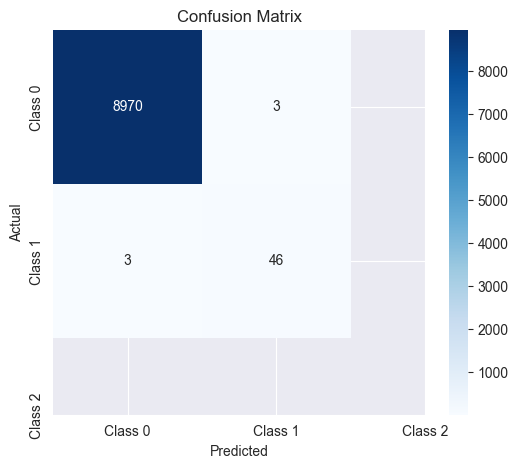

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()